In [1]:
%matplotlib inline
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from plots import *
import sys
import time
import datetime
sys.path.append('/home/hao/Research/probtorch/')
from torch.distributions.uniform import Uniform
from torch.distributions.normal import Normal
from torch.distributions.one_hot_categorical import OneHotCategorical as cat
from torch import logsumexp

import probtorch
from probtorch.util import expand_inputs

print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 1.0.0 cuda: True


In [8]:
T = 30
D = 2
K = 3

NUM_OBS = D * K + K
rws_samples = 50
steps = 5
## Model Parameters
NUM_HIDDEN = 128
NUM_LATENT = D * K
BATCH_SIZE = 100
NUM_EPOCHS = 1000
LEARNING_RATE = 1e-4
CUDA = False

In [9]:
Ys = torch.from_numpy(np.load('gmm_dataset/sequences.npy')).float()
Zs_true = np.load('gmm_dataset/states.npy')
mu_ks = torch.from_numpy(np.load('gmm_dataset/means.npy')).float()
cov_ks = torch.from_numpy(np.load('gmm_dataset/covariances.npy')).float()
Pi = torch.from_numpy(np.load('gmm_dataset/init.npy')).float()

num_seqs = Ys.shape[0]

In [10]:
class Encoder(nn.Module):
    def __init__(self, num_obs=NUM_OBS,
                       num_hidden=NUM_HIDDEN,
                       num_latents=NUM_LATENT):
        super(self.__class__, self).__init__()
        self.enc_hidden = nn.Sequential(
            nn.Linear(num_obs, num_hidden),
            nn.Tanh())
        self.mean = nn.Sequential(
            nn.Linear(num_hidden, num_latents))
        self.log_std = nn.Sequential(
            nn.Linear(num_hidden, num_latents))
        
    def forward(self, obs, K, D):
        hidden = self.enc_hidden(obs)
        mean = self.mean(hidden).view(-1, K, D)
        std = torch.exp(self.log_std(hidden).view(-1, K, D))
        mus = Normal(mean, std).sample()
        return mean, std, mus

In [11]:
def initialize():
    enc = Encoder()
    if CUDA:
        enc.cuda()
    optimizer =  torch.optim.Adam(list(enc.parameters()),lr=LEARNING_RATE)    
    return enc, optimizer
enc, optimizer = initialize()

In [12]:
def flatz(Z, T, K, batch_size):
    return torch.cat((Z[:, :T-1, :].unsqueeze(2), Z[:, 1:, :].unsqueeze(2)), 2).view(batch_size * (T-1), 2*K)

def init_mus(K, D, batch_size):
    mus = Normal(torch.zeros((batch_size, K, D)), torch.ones((batch_size, K, D))  * 0.5).sample()
    log_p_init = Normal(torch.zeros((batch_size, K, D)), torch.ones((batch_size, K, D))  * 0.5).log_prob(mus).sum(-1).sum(-1)
    return mus, log_p_init

def E_step_gmm(mus, Sigmas, Ys, T, D, K):
    ## Ys is B-by-T-by-D
    log_gammas = Normal(mus.unsqueeze(0).repeat(T, 1, 1, 1).transpose(0,2), Sigmas.unsqueeze(0).repeat(T, 1, 1, 1).transpose(0,2)).log_prob(Ys).sum(-1).transpose(0,1).transpose(1,2)
    gammas = torch.exp(log_gammas - logsumexp(log_gammas, -1).unsqueeze(-1))
    Z = cat(gammas).sample()
    log_qz = cat(F.softmax(gammas, -1)).log_prob(Z).sum(-1)
    return Z, log_qz

def log_qs_gmm(mean, std, mus):
    log_q = Normal(mean, std).log_prob(mus).sum(-1).sum(-1)
    return log_q

def log_joints_gmm(Z, Pi, mus, Sigmas, Ys, T, D, K, batch_size):
    log_probs = torch.zeros(batch_size).float()
    ## mus B-by-K-by-D
    log_probs = log_probs + Normal(torch.zeros((batch_size, K, D)), torch.ones((batch_size, K, D)) * 0.5).log_prob(mus).sum(-1).sum(-1)
    ## Z B-by-T-by-K
    log_probs = log_probs + cat(Pi).log_prob(Z).sum(-1)
    labels = Z.nonzero()
    log_probs = log_probs + Normal(mus[labels[:, 0], labels[:, -1]].view(batch_size, T, D), Sigmas[labels[:, 0], labels[:, -1]].view(batch_size, T, D)).log_prob(Ys).sum(-1).sum(-1)
    return log_probs

def eubo_gmm_rws(enc, Pi, Sigmas, Ys, T, D, K, rws_samples, steps, batch_size):
    """
    rws gradient estimator
    sis sampling scheme
    no resampling
    """
    log_increment_weights = torch.zeros((steps, rws_samples, batch_size))
    log_uptonow_weights = torch.zeros((steps, rws_samples, batch_size))
    for m in range(steps):
        if m == 0:
            for l in range(rws_samples):
                mus, log_p_init = init_mus(K, D, batch_size)
                Z, log_qz = E_step_gmm(mus, Sigmas, Ys, T, D, K)
                ## the first incremental weight is just log normalizer since As is sampled from prior
                log_p_joint = log_joints_gmm(Z, Pi, mus, Sigmas, Ys, T, D, K, batch_size)
                log_increment_weights[m, l] = log_p_joint - log_p_init - log_qz
                log_uptonow_weights[m, l] = log_p_joint - log_p_init - log_qz

        else:
            for l in range(rws_samples):
                stats1 = Z.sum(1)
                stats2 = torch.mul(stats1.unsqueeze(-1).unsqueeze(-1).repeat(1, 1, T, D).transpose(0, 1), Ys.unsqueeze(0).repeat(K, 1, 1, 1)).sum(2).transpose(0,1).contiguous().view(-1, K*D) ## should be B-K*D
                stats = torch.cat((stats1, stats2), -1)
                mean, std, mus = enc(stats, K, D)
                log_q_mus = Normal(mean, std).log_prob(mus).sum(-1).sum(-1)
                Z, log_qz = E_step_gmm(mus, Sigmas, Ys, T, D, K)
                ## the first incremental weight is just log normalizer since As is sampled from prior
                log_p_joint = log_joints_gmm(Z, Pi, mus, Sigmas, Ys, T, D, K, batch_size)
                log_increment_weights[m, l] = log_p_joint - log_q_mus - log_qz
                log_uptonow_weights[m, l] = log_uptonow_weights[m-1, l] + log_increment_weights[m, l]
    weights = torch.exp(log_uptonow_weights - logsumexp(log_uptonow_weights, 1).unsqueeze(1).repeat(1, rws_samples, 1)).detach()
    eubo = torch.mul(weights, log_increment_weights).sum(1).sum(0).mean()
    elbo = log_increment_weights.sum(0).mean(0).mean()
    ess = 1./ (weights[-1] ** 2).sum(1)
    return eubo, elbo, ess 

In [13]:
EUBOs = []
ELBOs = []
ESSs = []
Sigmas = torch.diagonal(cov_ks, 0, -2, -1).unsqueeze(0).repeat(BATCH_SIZE, 1, 1)
Grad_Steps = int((Ys.shape[0] / BATCH_SIZE))
for epoch in range(NUM_EPOCHS):
#     np.random.shuffle(Ys_Zs)
    indices = torch.randperm(num_seqs)
#     Ys_shuffled = torch.from_numpy(Ys_Zs[:, :, :2]).float()
#     Zs_true_shuffled = torch.from_numpy(Ys_Zs[:, :, 2:]).float()
    for step in range(Grad_Steps):
        time_start = time.time()
        optimizer.zero_grad()
        batch_indices = indices[step*BATCH_SIZE : (step+1)*BATCH_SIZE]
        batch_data = Ys[batch_indices]
        eubo, elbo = eubo_gmm_rws(enc, Pi, Sigmas, batch_data, T, D, K, rws_samples, steps, BATCH_SIZE)
        eubo.backward()
        optimizer.step()
        EUBOs.append(eubo.item())
        ELBOs.append(elbo.item())
    
        time_end = time.time()
        print('iteration: %d, EUBO : %f, ELBO : %f (%ds)' % (epoch*Grad_Steps+step, eubo, elbo, time_end - time_start))

iteration: 0, EUBO : -1622.852539, ELBO : -1919.715576 (2s)
iteration: 1, EUBO : -1630.539673, ELBO : -1943.644653 (2s)
iteration: 2, EUBO : -1616.107666, ELBO : -1919.119995 (1s)
iteration: 3, EUBO : -1602.652832, ELBO : -1912.339111 (1s)
iteration: 4, EUBO : -1596.050903, ELBO : -1900.983154 (2s)
iteration: 5, EUBO : -1641.996094, ELBO : -1929.222046 (2s)
iteration: 6, EUBO : -1604.303711, ELBO : -1902.790771 (1s)
iteration: 7, EUBO : -1601.426270, ELBO : -1912.208130 (1s)
iteration: 8, EUBO : -1629.720337, ELBO : -1930.871704 (2s)
iteration: 9, EUBO : -1595.321533, ELBO : -1896.315308 (2s)
iteration: 10, EUBO : -1588.602173, ELBO : -1892.149414 (1s)
iteration: 11, EUBO : -1625.972168, ELBO : -1921.812866 (1s)
iteration: 12, EUBO : -1603.015747, ELBO : -1911.997314 (2s)
iteration: 13, EUBO : -1607.517334, ELBO : -1906.683105 (1s)
iteration: 14, EUBO : -1603.802490, ELBO : -1906.062500 (1s)
iteration: 15, EUBO : -1591.175659, ELBO : -1903.533447 (1s)
iteration: 16, EUBO : -1600.091431

In [15]:
def plot_results(EUBOs, ELBOs):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax1 = fig.add_subplot(1,1,1)
    ax1.plot(ELBOs, 'b-', label='elbo')
    ax1.plot(EUBOs, 'r-', label='eubo')
    ax1.legend(fontsize=18)
    ax1.set_xlabel('epoch', fontsize=16)
    ax1.set_ylabel('EUBO and ELBO', fontsize=16)
    ax1.tick_params(labelsize=18)

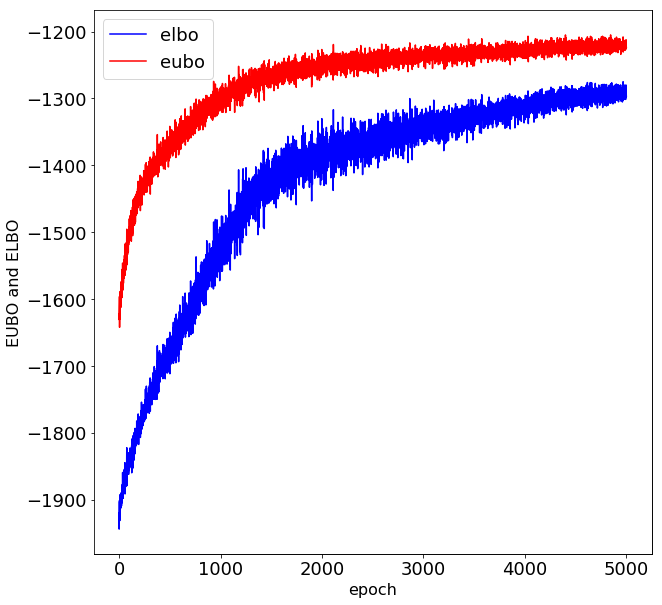

In [16]:
plot_results(EUBOs, ELBOs)